In [80]:
import pandas as pd
import numpy as np

import time, warnings
import datetime as dt

#modules for predictive models
import sklearn.cluster as cluster
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA



from sklearn.metrics import silhouette_samples, silhouette_score

#visualizations
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
%matplotlib inline
import seaborn as sns

warnings.filterwarnings("ignore")

In [7]:
retail_df= pd.read_excel(r"C:\Users\Shrushti\Downloads\Online Retail.xlsx")

In [8]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [10]:
print(retail_df.shape)

(541909, 8)


In [12]:
retail_df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [13]:
retail_df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [23]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


# CLEANING THE DATA

In [9]:
#Limiting customer data to UK residents as most clusters are there
retail_uk = retail_df[retail_df['Country']=='United Kingdom']
retail_uk.shape

(495478, 8)

In [16]:
#remove cancelled orders
retail_uk = retail_uk[retail_uk['Quantity']>0]
retail_uk.shape

(486286, 8)

In [17]:
#remove rows where customerID are NA
retail_uk.dropna(subset=['CustomerID'],how='all',inplace=True)
retail_uk.shape

(354345, 8)

In [18]:
#restrict the data to one full year because it's better to use a metric per Months or Years in RFM
retail_uk = retail_uk[retail_uk['InvoiceDate']>= "2010-12-09"]
retail_uk.shape

(342478, 8)

In [22]:
print("Summary:")
#exploring the unique values of each attribute
print("Number of transactions: ", retail_uk['InvoiceNo'].nunique())
print("Number of products bought: ",retail_uk['StockCode'].nunique())
print("Number of customers:", retail_uk['CustomerID'].nunique() )
print("Percentage of customers NA: ", round(retail_uk['CustomerID'].isnull().sum() * 100 / len(retail_df),2),"%" )


Summary:
Number of transactions:  16017
Number of products bought:  3611
Number of customers: 3863
Percentage of customers NA:  0.0 %


# RFM Analysis

RFM (Recency, Frequency, Monetary) analysis is a customer segmentation technique that uses past purchase behavior to divide customers into groups.

## Recency

How many days ago was the customer's last purchase.

In [24]:
#last date available in our dataset
retail_uk['InvoiceDate'].max()

Timestamp('2011-12-09 12:49:00')

In [27]:
now = dt.date(2021,4,20)
print(now)

2021-04-20


In [28]:
#create a new column called date which contains the date of invoice only
retail_uk['date'] = retail_uk['InvoiceDate'].dt.date
retail_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date
19632,537879,22114,HOT WATER BOTTLE TEA AND SYMPATHY,12,2010-12-09 08:34:00,3.95,14243.0,United Kingdom,2010-12-09
19633,537879,22835,HOT WATER BOTTLE I AM SO POORLY,8,2010-12-09 08:34:00,4.65,14243.0,United Kingdom,2010-12-09
19634,537879,85150,LADIES & GENTLEMEN METAL SIGN,6,2010-12-09 08:34:00,2.55,14243.0,United Kingdom,2010-12-09
19635,537879,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,4,2010-12-09 08:34:00,7.95,14243.0,United Kingdom,2010-12-09
19636,537879,21524,DOORMAT SPOTTY HOME SWEET HOME,2,2010-12-09 08:34:00,7.95,14243.0,United Kingdom,2010-12-09


In [29]:
#group by customers and check last date of purshace
recency_df = retail_uk.groupby(by='CustomerID', as_index=False)['date'].max()
recency_df.columns = ['CustomerID','LastPurshaceDate']
recency_df.head()

,CustomerID,LastPurshaceDate
0,12346.0,2011-01-18
1,12747.0,2011-12-07
2,12748.0,2011-12-09
3,12749.0,2011-12-06
4,12820.0,2011-12-06


In [30]:
recency_df['Recency'] = recency_df['LastPurshaceDate'].apply(lambda x: (now - x).days)

In [31]:
recency_df.head()

,CustomerID,LastPurshaceDate,Recency
0,12346.0,2011-01-18,3745
1,12747.0,2011-12-07,3422
2,12748.0,2011-12-09,3420
3,12749.0,2011-12-06,3423
4,12820.0,2011-12-06,3423


In [32]:
#drop LastPurchaseDate as we don't need it anymore
recency_df.drop('LastPurshaceDate',axis=1,inplace=True)

Now we have the recency attribute created. e.g: Customer with ID = 12346 did his/her last purshace 3745 days ago.

## Frequency

how many times a customer purchased from us

In [33]:
#drop duplicates
retail_uk_copy = retail_uk
retail_uk_copy.drop_duplicates(subset=['InvoiceNo', 'CustomerID'], keep="first", inplace=True)
#calculate frequency of purchases
frequency_df = retail_uk_copy.groupby(by=['CustomerID'], as_index=False)['InvoiceNo'].count()
frequency_df.columns = ['CustomerID','Frequency']
frequency_df.head()

,CustomerID,Frequency
0,12346.0,1
1,12747.0,10
2,12748.0,196
3,12749.0,5
4,12820.0,4


## Monetary

How much money did the customer spent over time

In [34]:
#create column total cost
retail_uk['TotalCost'] = retail_uk['Quantity'] * retail_uk['UnitPrice']

In [35]:
monetary_df = retail_uk.groupby(by='CustomerID',as_index=False).agg({'TotalCost': 'sum'})
monetary_df.columns = ['CustomerID','Monetary']
monetary_df.head()

,CustomerID,Monetary
0,12346.0,77183.60
1,12747.0,658.89
2,12748.0,3739.23
3,12749.0,98.35
4,12820.0,58.20


# Create RFM Table

In [36]:
#merge recency dataframe with frequency dataframe
temp_df = recency_df.merge(frequency_df,on='CustomerID')
temp_df.head()

,CustomerID,Recency,Frequency
0,12346.0,3745,1
1,12747.0,3422,10
2,12748.0,3420,196
3,12749.0,3423,5
4,12820.0,3423,4


In [37]:
#merge with monetary dataframe to get a table with the 3 columns
rfm_df = temp_df.merge(monetary_df,on='CustomerID')
#use CustomerID as index
rfm_df.set_index('CustomerID',inplace=True)
#check the head
rfm_df.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,3745,1,77183.60
12747.0,3422,10,658.89
12748.0,3420,196,3739.23
12749.0,3423,5,98.35
12820.0,3423,4,58.20


## RFM Table Correctness verification

In [38]:
retail_uk[retail_uk['CustomerID']==12346.0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date,TotalCost
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,2011-01-18,77183.6


In [41]:
(now - dt.date(2011,1,18)).days == 3745

True

As we can see our RFM table is correct. The first customer bought only once, and only one product with huge amount.

# Customer segments with RFM Model

In [42]:
#get the 80% of the revenue
pareto_cutoff = rfm_df['Monetary'].sum() * 0.8
print("The 80% of total revenue is: ",round(pareto_cutoff,2))

The 80% of total revenue is:  890679.54


In [43]:
customers_rank = rfm_df
# Create a new column that is the rank of the value of coverage in ascending order
customers_rank['Rank'] = customers_rank['Monetary'].rank(ascending=0)
#customers_rank.drop('RevenueRank',axis=1,inplace=True)
customers_rank.head()

,Recency,Frequency,Monetary,Rank
CustomerID,,,,
12346.0,3745,1,77183.60,2.0
12747.0,3422,10,658.89,183.0
12748.0,3420,196,3739.23,34.0
12749.0,3423,5,98.35,1140.0
12820.0,3423,4,58.20,1665.5


In [44]:
customers_rank.sort_values('Rank',ascending=True)

,Recency,Frequency,Monetary,Rank
CustomerID,,,,
16446.0,3420,2,168471.25,1.0
12346.0,3745,1,77183.60,2.0
15098.0,3602,3,39916.50,3.0
18102.0,3420,57,39646.45,4.0
17949.0,3421,44,28685.69,5.0
...,...,...,...,...
15503.0,3782,1,0.42,3859.5
15645.0,3438,1,0.42,3859.5
17914.0,3423,1,0.39,3861.5


In [45]:
#get top 20% of the customers
top_20_cutoff = 3863 *20 /100
top_20_cutoff

772.6

In [46]:
#sum the monetary values over the customer with rank <=773
revenueByTop20 = customers_rank[customers_rank['Rank'] <= 772]['Monetary'].sum()
revenueByTop20

976683.3499999999

# Applying RFM score formula

### RFM Quartiles

In [47]:
quantiles = rfm_df.quantile(q=[0.25,0.5,0.75])
quantiles

,Recency,Frequency,Monetary,Rank
0.25,3437.0,1.0,17.4,966.5
0.50,3469.0,2.0,45.0,1930.5
0.75,3554.0,5.0,121.6,2898.0


In [48]:
quantiles.to_dict()

{'Recency': {0.25: 3437.0, 0.5: 3469.0, 0.75: 3554.0},
 'Frequency': {0.25: 1.0, 0.5: 2.0, 0.75: 5.0},
 'Monetary': {0.25: 17.4, 0.5: 45.0, 0.75: 121.6},
 'Rank': {0.25: 966.5, 0.5: 1930.5, 0.75: 2898.0}}

#### Creation of RFM segmentation table

We will create two segmentation classes since, high recency is bad, while high frequency and monetary value is good.

In [49]:

# Arguments (x = value, p = recency, monetary_value, frequency, d = quartiles dict)
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [50]:
#create rfm segmentation table
rfm_segmentation = rfm_df
rfm_segmentation['R_Quartile'] = rfm_segmentation['Recency'].apply(RScore, args=('Recency',quantiles,))
rfm_segmentation['F_Quartile'] = rfm_segmentation['Frequency'].apply(FMScore, args=('Frequency',quantiles,))
rfm_segmentation['M_Quartile'] = rfm_segmentation['Monetary'].apply(FMScore, args=('Monetary',quantiles,))

In [51]:
rfm_segmentation.head()

,Recency,Frequency,Monetary,Rank,R_Quartile,F_Quartile,M_Quartile
CustomerID,,,,,,,
12346.0,3745,1,77183.60,2.0,1,1,4
12747.0,3422,10,658.89,183.0,4,4,4
12748.0,3420,196,3739.23,34.0,4,4,4
12749.0,3423,5,98.35,1140.0,4,3,3
12820.0,3423,4,58.20,1665.5,4,3,3


In [52]:
#Combined Scores
rfm_segmentation['RFMScore'] = rfm_segmentation.R_Quartile.map(str) \
                            + rfm_segmentation.F_Quartile.map(str) \
                            + rfm_segmentation.M_Quartile.map(str)
rfm_segmentation.head()

,Recency,Frequency,Monetary,Rank,R_Quartile,F_Quartile,M_Quartile,RFMScore
CustomerID,,,,,,,,
12346.0,3745,1,77183.60,2.0,1,1,4,114
12747.0,3422,10,658.89,183.0,4,4,4,444
12748.0,3420,196,3739.23,34.0,4,4,4,444
12749.0,3423,5,98.35,1140.0,4,3,3,433
12820.0,3423,4,58.20,1665.5,4,3,3,433


In [53]:
#Best Customers
rfm_segmentation[rfm_segmentation['RFMScore']=='444'].sort_values('Monetary', ascending=False).head(10)

,Recency,Frequency,Monetary,Rank,R_Quartile,F_Quartile,M_Quartile,RFMScore
CustomerID,,,,,,,,
18102.0,3420,57,39646.45,4.0,4,4,4,444
17949.0,3421,44,28685.69,5.0,4,4,4,444
17450.0,3428,44,25953.51,6.0,4,4,4,444
16013.0,3423,45,17163.28,8.0,4,4,4,444
16333.0,3427,22,14418.96,9.0,4,4,4,444
15769.0,3427,25,11660.84,11.0,4,4,4,444
12901.0,3428,28,9230.45,12.0,4,4,4,444
13798.0,3421,56,7786.26,13.0,4,4,4,444
16684.0,3424,28,7700.08,14.0,4,4,4,444


Best Recency score = 4: most recently purchase. Best Frequency score = 4: most quantity purchase. Best Monetary score = 4: spent the most.

In [54]:
#How any Customers in each segment
print("Best Customers: ",len(rfm_segmentation[rfm_segmentation['RFMScore']=='444']))
print('Loyal Customers: ',len(rfm_segmentation[rfm_segmentation['F_Quartile']==4]))
print("Big Spenders: ",len(rfm_segmentation[rfm_segmentation['M_Quartile']==4]))
print('Almost Lost: ', len(rfm_segmentation[rfm_segmentation['RFMScore']=='244']))
print('Lost Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='144']))
print('Lost Cheap Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='111']))

Best Customers:  356
Loyal Customers:  752
Big Spenders:  966
Almost Lost:  64
Lost Customers:  9
Lost Cheap Customers:  353


# Applying K-means clustering on RFM variables

## Preprocess Data

In [55]:
rfm_data = rfm_df.drop(['R_Quartile','F_Quartile','M_Quartile','RFMScore'],axis=1)
rfm_data.head()

,Recency,Frequency,Monetary,Rank
CustomerID,,,,
12346.0,3745,1,77183.60,2.0
12747.0,3422,10,658.89,183.0
12748.0,3420,196,3739.23,34.0
12749.0,3423,5,98.35,1140.0
12820.0,3423,4,58.20,1665.5


In [56]:
#Feature Correlations
rfm_data.corr()

,Recency,Frequency,Monetary,Rank
Recency,1.000000,-0.279236,-0.027727,0.323089
Frequency,-0.279236,1.000000,0.156431,-0.458850
Monetary,-0.027727,0.156431,1.000000,-0.130520
Rank,0.323089,-0.458850,-0.130520,1.000000


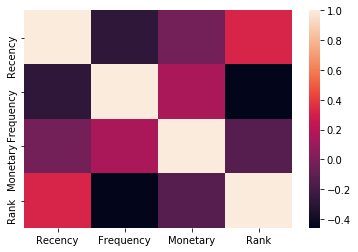

In [57]:
sns.heatmap(rfm_data.corr())

On one hand, we have a negative correlation between:
Recency and Frequency
Recency and Monetary

On the other hand, the correlation between Monetary and Frequency is positive comparing to negative ones but still not that strong.

#### Visualize feature distributions

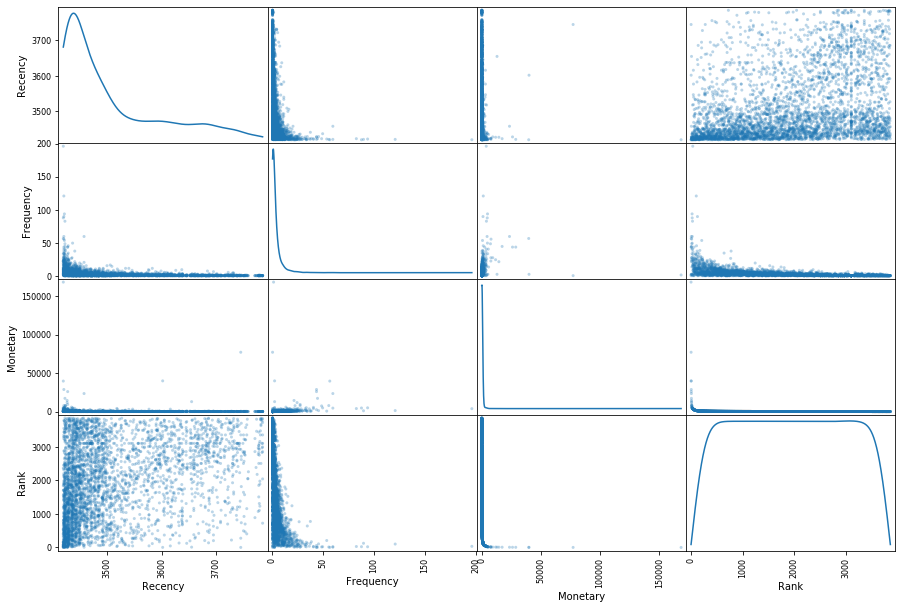

In [64]:
# Produce a scatter matrix for each pair of features in the data
scatter_matrix(rfm_data, alpha = 0.3, figsize = (15,10), diagonal = 'kde');

We can notice that we have a skewed distribution of the 3 variables and there exist outliers.

This indicates how normalization is required to make the data features normally distributed as clustering algorithms require them to be normally distributed.

#### Data Normalization

In [59]:
#log transformation
rfm_r_log = np.log(rfm_data['Recency']+0.1) #can't take log(0) and so add a small number
rfm_f_log = np.log(rfm_data['Frequency'])
rfm_m_log = np.log(rfm_data['Monetary']+0.1)

In [60]:
log_data = pd.DataFrame({'Monetary': rfm_m_log,'Recency': rfm_r_log,'Frequency': rfm_f_log})

In [61]:
log_data.head()

,Monetary,Recency,Frequency
CustomerID,,,
12346.0,11.253944,8.228204,0.000000
12747.0,6.490708,8.138010,2.302585
12748.0,8.226662,8.137425,5.278115
12749.0,4.589549,8.138302,1.609438
12820.0,4.065602,8.138302,1.386294


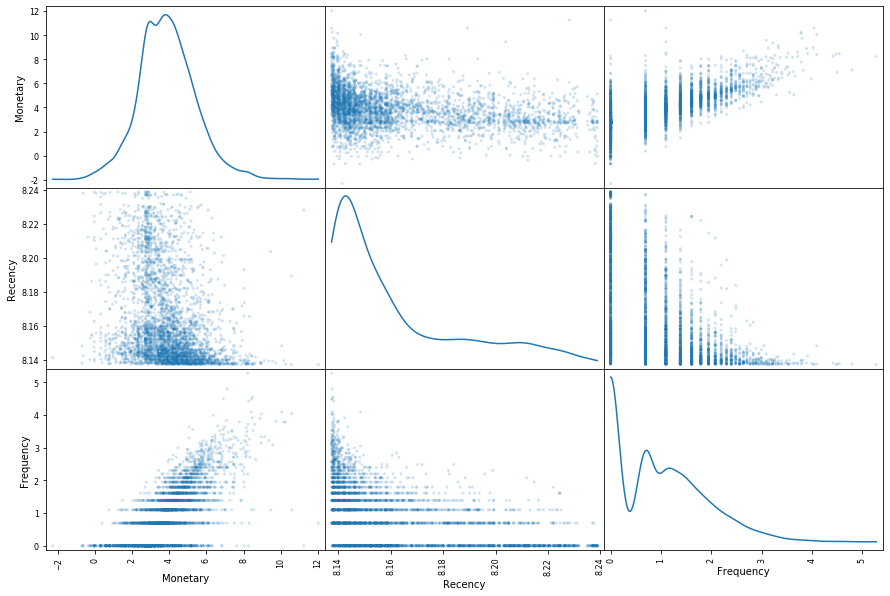

In [63]:
# Produce a scatter matrix for each pair of features in the data
scatter_matrix(log_data, alpha = 0.2, figsize = (15,10), diagonal = 'kde');

The distributions of Frequency and Monetary are better, more normalized, but it's not the case with Recency Distribution, which is improved but not as much.

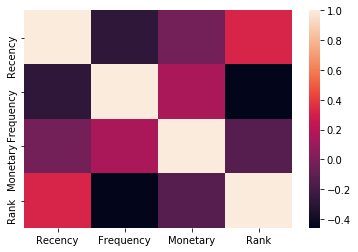

In [65]:
sns.heatmap(rfm_data.corr())

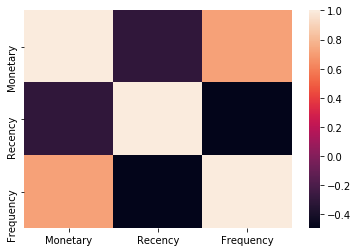

In [66]:
sns.heatmap(log_data.corr())

In [68]:
log_data.corr()

,Monetary,Recency,Frequency
Monetary,1.000000,-0.300536,0.715609
Recency,-0.300536,1.000000,-0.491490
Frequency,0.715609,-0.491490,1.000000


Now, Monetary and Frequency are more strongly correlated

## K-means Implementation

In [75]:
matrix = log_data.to_numpy()
for n_clusters in range(2,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.4837178953715137
For n_clusters = 3 The average silhouette_score is : 0.4361057712217044
For n_clusters = 4 The average silhouette_score is : 0.39150832418201503
For n_clusters = 5 The average silhouette_score is : 0.3999546750605369
For n_clusters = 6 The average silhouette_score is : 0.4160065197475875
For n_clusters = 7 The average silhouette_score is : 0.40755603369423854
For n_clusters = 8 The average silhouette_score is : 0.4134700852709236
For n_clusters = 9 The average silhouette_score is : 0.403328889406896


## The best silhouette score obtained is when the number of clusters is 2.

In [77]:
n_clusters = 2
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
kmeans.fit(matrix)
clusters_customers = kmeans.predict(matrix)
silhouette_avg = silhouette_score(matrix, clusters_customers)
print('score de silhouette: {:<.3f}'.format(silhouette_avg))

score de silhouette: 0.484


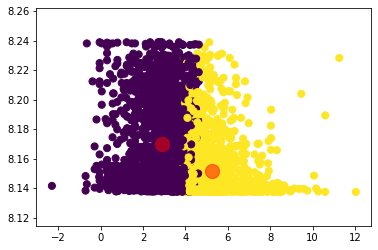

In [81]:
#Visualize Cluster
#create a scatter plot
plt.scatter(matrix[:, 0], matrix[:, 1], c=clusters_customers, s=50, cmap='viridis')
#select cluster centers
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5);

In [79]:
# What's the number of customers in each cluster?
pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns = ['NumberCustomers']).T

,0,1
NumberCustomers,2230,1633
